In [1]:
from dataloaders.pc_camview_dataset import SemanticKITTI
import argparse
import yaml
from easydict import EasyDict
from PIL import Image
from torchvision.transforms import transforms
import numpy as np
from torch.utils.data import DataLoader
from sparse2dense._2dpapenet_camview import get_model as DepthCompletionModel
from matplotlib import cm
import torch

totensor = transforms.ToTensor()
topil = transforms.ToPILImage()

args = argparse.ArgumentParser()
args = args.parse_args(args=[])
with open('./config/semantic_camview.yaml') as stream:
    config = yaml.safe_load(stream)
config.update(vars(args))
args = EasyDict(config)
dataset = SemanticKITTI(args=args)
dataloader = DataLoader(dataset, 1, False)

with torch.no_grad():
    model = DepthCompletionModel(args).cuda()
    model = model.load_from_checkpoint('/root/autodl-nas/best_2dpapenet_conv.ckpt', args=args).cuda()
    # model = model.load_from_checkpoint('/root/autodl-nas/best_2dpapenet_128.ckpt', args=args).cuda()
    # model = model.load_from_checkpoint('/root/autodl-nas/sparse2dense_s2/best_2dpapenet.ckpt', args=args, strict=False).cuda()

In [2]:
cur_iter = iter(dataloader)
for frame in range(len(dataloader)):
    cur_data = next(cur_iter)
    H = cur_data['velodyne_proj_img'].shape[2]
    W = cur_data['velodyne_proj_img'].shape[3]
    H_up = int(cur_data['coord_lines'][0].squeeze()[:,0].max())
    with torch.no_grad():
        output_data = model(cur_data)
    fuse_output = output_data['fuse_output'].data.cpu().numpy().squeeze()

    coordinate = np.indices((H - H_up, W)).reshape((2, -1)).transpose(1, 0)
    coordinate[:, 0:1] += H_up
    depth = fuse_output[coordinate[:, 0], coordinate[:, 1]]
    depth = depth.reshape((depth.shape[0], 1))
    uvd1 = np.concatenate([np.fliplr(coordinate*depth), depth, np.ones(depth.shape)], axis=-1)

    proj_matrix = np.identity(4)
    proj_matrix[:3, :4] = cur_data['proj_matrix'].cpu().numpy().squeeze()
    proj_matrix_inv = cur_data['proj_matrix_inv'].cpu().numpy().squeeze()

    dense_points = (proj_matrix_inv @ uvd1.T).T
    max_dist = float(output_data['distance'].max())
    cur_diatance = np.linalg.norm(dense_points, axis=1).astype(np.float32)
    # print(dense_points.shape)
    dense_points = dense_points[cur_diatance < max_dist]
    # print(dense_points.shape)
    
    dense_points = dense_points.astype(np.float32)
    dense_points.tofile(args['dataset_params']['data_path'] + '/03/denser/'+str(frame).zfill(6)+'.bin')

KeyboardInterrupt: 

In [3]:
'''penet'''

import torch
from penet.model import ENet as DepthCompletionModel
import sys
from dataloaders.pc_camview_dataset import SemanticKITTI
import argparse
import yaml
from easydict import EasyDict
import numpy as np
from torch.utils.data import DataLoader

args = argparse.ArgumentParser()
args = args.parse_args(args=[])
with open('./config/semantic_camview.yaml') as stream:
    config = yaml.safe_load(stream)
config.update(vars(args))
args = EasyDict(config)
dataset = SemanticKITTI(args=args)
dataloader = DataLoader(dataset, 1, False)
sys.path.append('/root/autodl-nas/PENet_ICRA2021')

device = torch.device('cuda')
checkpoint = torch.load('/root/autodl-nas/e.pth.tar', map_location=device)
with torch.no_grad():
    model = DepthCompletionModel().cuda()
    model.load_state_dict(checkpoint['model'], False)

In [4]:
cur_iter = iter(dataloader)
for frame in range(len(dataloader)):
    cur_data = next(cur_iter)
    H = cur_data['velodyne_proj_img'].shape[2]
    W = cur_data['velodyne_proj_img'].shape[3]
    H_up = int(cur_data['coord_lines'][0].squeeze()[:,0].max())
    with torch.no_grad():
        output_data = model(cur_data)
    fuse_output = output_data['fuse_output'].data.cpu().numpy().squeeze()

    coordinate = np.indices((H - H_up, W)).reshape((2, -1)).transpose(1, 0)
    coordinate[:, 0:1] += H_up
    depth = fuse_output[coordinate[:, 0], coordinate[:, 1]]
    depth = depth.reshape((depth.shape[0], 1))
    uvd1 = np.concatenate([np.fliplr(coordinate*depth), depth, np.ones(depth.shape)], axis=-1)

    proj_matrix = np.identity(4)
    proj_matrix[:3, :4] = cur_data['proj_matrix'].cpu().numpy().squeeze()
    proj_matrix_inv = cur_data['proj_matrix_inv'].cpu().numpy().squeeze()

    dense_points = (proj_matrix_inv @ uvd1.T).T
    max_dist = float(output_data['distance'].max())
    cur_diatance = np.linalg.norm(dense_points, axis=1).astype(np.float32)
    # print(dense_points.shape)
    dense_points = dense_points[cur_diatance < max_dist]
    # print(dense_points.shape)
    
    dense_points = dense_points.astype(np.float32)
    dense_points.tofile(args['dataset_params']['data_path'] + '/03/denser/'+str(frame).zfill(6)+'.bin')

KeyboardInterrupt: 

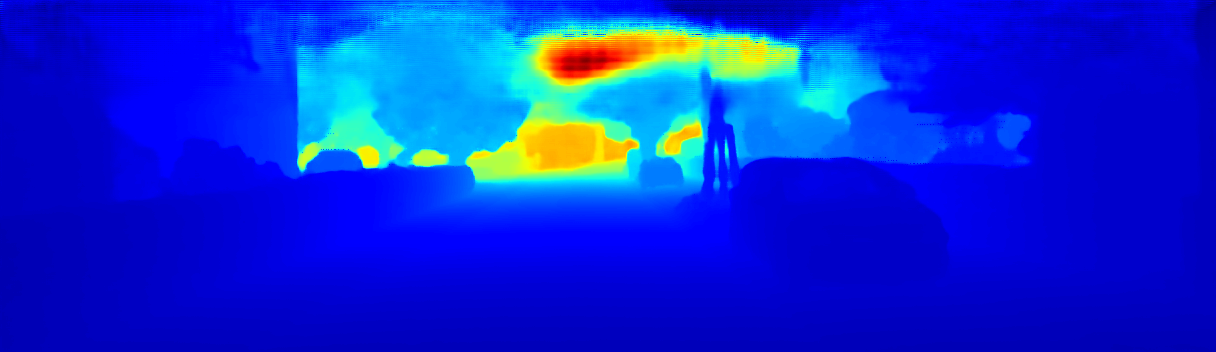

In [ ]:
'''penet'''

import torch
from penet.model import ENet as DepthCompletionModel
from matplotlib import cm
import sys

sys.path.append('/root/autodl-nas/PENet_ICRA2021')

device = torch.device('cuda')
checkpoint = torch.load('/root/autodl-nas/e.pth.tar', map_location=device)
model = DepthCompletionModel().cuda()
model.load_state_dict(checkpoint['model'], False)
with torch.no_grad():
    output_data = model(cur_data)
refine_img = output_data['fuse_output']

cmap = cm.get_cmap('jet')
sm = cm.ScalarMappable(cmap=cmap)
color_range = sm.to_rgba(np.linspace(0,1,256), bytes=True)[:, 0:3]

refine_img0 = output_data['fuse_output'].data.cpu().numpy()
img = np.squeeze(refine_img0/refine_img0.max()*255.).astype(np.uint8)
img = color_range[img].astype(np.uint8)
imgsave = Image.fromarray(img)
imgsave.show()

In [ ]:
raw_data = cur_data['raw_data'].cpu().numpy().squeeze()

denseW = W
denseH = H
startH = 2*H // 5

xx_ones = np.ones([denseH - startH], dtype=np.int32)
xx_ones = np.expand_dims(xx_ones, 1)
xx_range = np.expand_dims(np.arange(denseW), 0)
# [1 2 3 4 5 ...]
# [1 2 3 4 5 ...]
# [1 2 3 4 5 ...]
# ...
xx_channel = np.matmul(xx_ones, xx_range)
xx_channel = np.expand_dims(xx_channel, -1)

yy_ones = np.ones([denseW], dtype=np.int32)
yy_ones = np.expand_dims(yy_ones, 0)
yy_range = np.expand_dims(np.arange(startH, denseH), 1)
# [1 1 1 1 1 ...]
# [2 2 2 2 2 ...]
# [3 3 3 3 3 ...]
# ...
yy_channel = np.matmul(yy_range, yy_ones)
yy_channel = np.expand_dims(yy_channel, -1)

coordinate = np.concatenate([yy_channel, xx_channel], axis=-1).reshape((denseW * (denseH - startH), 2))

fuse_output = output_data['fuse_output'].data.cpu().numpy().squeeze()

depth = fuse_output[coordinate[:, 0], coordinate[:, 1]]
depth = depth.reshape((depth.shape[0], 1))
uvd1 = np.concatenate([np.fliplr(coordinate * depth), depth, np.ones(depth.shape)], axis=-1)

proj_matrix = np.identity(4)
proj_matrix[:3, :4] = cur_data['proj_matrix'].cpu().numpy().squeeze()
proj_matrix_inv = cur_data['proj_matrix_inv'].cpu().numpy().squeeze()

xyz1 = (proj_matrix_inv @ uvd1.T).T

# denserpc = xyz1
denserpc = np.concatenate([raw_data, xyz1], axis=0)
denserpc = denserpc.astype(np.float32)
denserpc.tofile('./bin/denserpc.bin')

In [ ]:
from projection.laserscan import LaserScan
import argparse
from torchvision.transforms import transforms
import numpy as np
import matplotlib
from matplotlib import cm
import yaml
args = argparse.ArgumentParser("test")
args.add_argument("--config", type=str, default= "./config/semantic-kitti.yaml")
args = args.parse_args(args=[])

with open(args.config) as config:
    CFG = yaml.safe_load(config)
color_dict = CFG['color_map']
topil = transforms.ToPILImage()

laserscan = LaserScan(project=True, H=64+32)
scan_path = "./bin/denserpc.bin"
# scan_path = "/root/autodl-tmp/SemanticKITTI/sequences/03/velodyne/000000.bin"
laserscan.open_scan(scan_path, scan_unfold=True)

# cmap = matplotlib.colormaps.get_cmap('viridis')
cmap = cm.get_cmap('viridis')
sm = cm.ScalarMappable(cmap=cmap)
color_range = sm.to_rgba(np.linspace(0,1,256), bytes=True)[:, 0:3]

range_img = laserscan.proj_range
range_img = ((range_img-range_img.min())/(range_img.max()-range_img.min())*255).astype(np.uint8)
range_img_color = color_range[range_img].astype(np.uint8)

range_img = topil(range_img_color)
range_img.show()


KeyboardInterrupt: 